In [44]:
import pandas as pd
import numpy as np
import scipy
import math
import time
import datetime
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

# Подход 1: градиентный бустинг "в лоб"

## 0 Считываем данные

In [12]:
features_raw = pd.read_csv('features.csv', index_col='match_id')
features_raw.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


### 1 Удалим признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [19]:
cols = [col for col in features_raw.columns if col not in ['start_time',
                                                       'duration', 
                                                       'tower_status_radiant', 
                                                       'tower_status_dire', 
                                                       'barracks_status_radiant',
                                                       'barracks_status_dire']]

Количество пропусков
 first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64


### 2 Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [22]:
features = features_raw[cols]
nans = len(features_raw) - features_u.count()
print ('Количество пропусков\n', nans[nans != 0])

Количество пропусков
 first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64


In [23]:
print (len(features_raw))

97230


first_blood_time - в течении первых 5 минут не наступило событие 'первая кровь';
first_blood_team - 'первая кровь' не наступило -> нет команды, совершившей событие;
first_blood_player1 - 'первая кровь' не наступило -> нет игрока, совершившего событие;
first_blood_player2 - 'первая кровь' не наступило -> нет игрока, помогшего совершить событие;
radiant_bottle_time - в течении первых 5 минут не было приобретения предмета bottle командой radiant;
radiant_courier_time - в течении первых 5 минут не было приобретения предмета courier командой radiant;
radiant_flying_courier_time - в течении первых 5 минут не было приобретения предмета flying_courier командой radiant;
radiant_first_ward_time - в течении первых 5 минут командой radiant не был установлен ни один наблюдатель;
dire_bottle_time - в течении первых 5 минут не было приобретения предмета bottle командой dire;
dire_courier_time - в течении первых 5 минут не было приобретения предмета courier командой dire;
dire_flying_courier_time - в течении первых 5 минут не было приобретения предмета flying_courier командой dire;
dire_first_ward_time - в течении первых 5 минут командой dire не был установлен ни один наблюдатель;

### 3 Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева.

In [33]:
features = features.fillna(value = 0)

### 4 Выделим целевую переменную

In [34]:
X = features.drop('radiant_win', axis = 1)
y = features['radiant_win']


###  5 Градиентный бустинг
Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". 

Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. 

Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

#### 5.1 разобьем выборку на обучающую и тестовую и создадим генератор разбиений для кросс-валидации:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.5, 
                                                    random_state = 1)

kF = KFold(random_state = 1,
          n_splits = 5,
          shuffle = True)

#### 5.2 Оценим качество градиентного бустинга с помощью данной кросс-валидации, попробуем при этом разное количество деревьев (10, 20, 30)

In [36]:
# создадим классификатор
clf = GradientBoostingClassifier(verbose = 0, random_state = 1)

params = {'n_estimators':[10, 20, 30]}
clf_grid = GridSearchCV(clf, 
                        params,
                        cv = kF,
                        scoring = 'roc_auc'
                       )
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'n_estimators': [10, 20, 30]}, scoring='roc_auc')

In [46]:
def display_roc_curve(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label = u'ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Gradient Boosting on train data')
    plt.legend(loc = "lower right")
    plt.show()

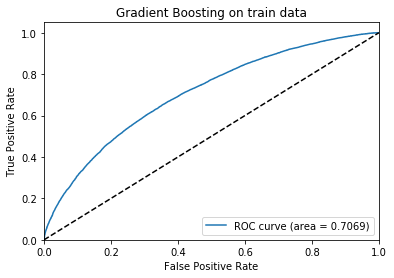

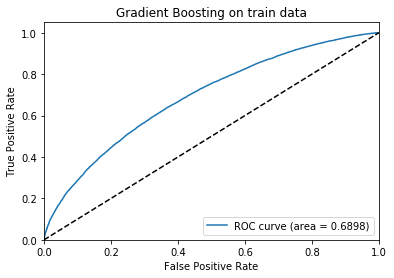

In [47]:
y_train_score = clf_grid.decision_function(X_train)
y_test_score = clf_grid.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_train, y_train_score)
display_roc_curve(fpr, tpr)
fpr, tpr, _ = roc_curve(y_test, y_test_score)
display_roc_curve(fpr, tpr)


#### 5.3 Выясним, достигнут ли оптимум на испытанных значениях параметра n_estimators

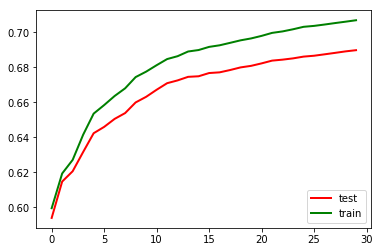

In [49]:
y_score_train = np.empty(len(clf_grid.best_estimator_.estimators_))
y_score_test = np.empty(len(clf_grid.best_estimator_.estimators_))
n = 0
for i, x in enumerate(clf_grid.best_estimator_.staged_decision_function(X_train) ):
    y_score_train[i] = roc_auc_score(y_train, x)
for i, x in enumerate(clf_grid.best_estimator_.staged_decision_function(X_test) ):
    y_score_test[i] = roc_auc_score(y_test, x)

plt.figure()
plt.plot(y_score_test, 'r', linewidth = 2)
plt.plot(y_score_train, 'g', linewidth = 2)
plt.legend(['test', 'train'], loc="lower right")

Видно, что график качества от количества деревьев еще не вышел на плато -> увеличение количества классификаторов имеет смысл 

### 5.4 Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? 

In [52]:
clf_1 = GradientBoostingClassifier(verbose = 0,
                                random_state = 1,
                                n_estimators = 30)
start_time = datetime.datetime.now()
val = cross_val_score(estimator = clf_1,
                     X = X_train,
                     y = y_train,
                     scoring = 'roc_auc',
                     cv = kF)

print ('Time elapsed:', datetime.datetime.now() - start_time)
print ('ROC_AUC:', str(val.mean()))

Time elapsed: 0:01:15.385487
ROC_AUC: 0.688041165746734


# Подход 2: логистическая регрессия

### Отмасштабируем признаки, т.к. линейные модели чувствительны к масштабу

In [54]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))
X_scaled.columns = X.columns

### разобьем выборку на обучающую и тестовую и создадим генератор разбиений для кросс-валидации:

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size = 0.5, 
                                                    random_state = 1)

### 1 Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [59]:
lg_grid = {'C': np.power(10.0, np.arange(-5, 6, 1))}
clf_lg= LogisticRegression(random_state = 1, verbose = 0)
clf_lg_grid = GridSearchCV(clf_lg, 
                               lg_grid,
                               cv = kF,
                               scoring = 'roc_auc'
                               )
clf_lg_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=1),
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             scoring='roc_auc')

In [61]:
y_train_score_lg = clf_lg_grid.decision_function(X_train)
y_test_score_lg = clf_lg_grid.decision_function(X_test)

print (clf_lg_grid.best_params_)
print (roc_auc_score(y_train, y_train_score_lg))
print (roc_auc_score(y_test, y_test_score_lg))

{'C': 0.01}
0.7199841528820664
0.7141008077183394


Качество модели логистической регрессии выше, чем у градиентного бустинга. 

Это может быть вызвано тем, что для градиентного бустинга подобраны не оптимальные параметры (кол-во деревьев) или данные линейно разделимы в пространстве признаков. 

Логистическая регрессия работает быстрее градиентного бустинга

### 2 Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [62]:
cols = [col for col in X_scaled.columns if col not in ['r1_hero', 'd1_hero', 
                                                       'r2_hero', 'd2_hero', 
                                                       'r3_hero', 'd3_hero', 
                                                       'r4_hero', 'd4_hero', 
                                                       'r5_hero', 'd5_hero', 
                                                       'lobby_type']]
X_lg = X_scaled[cols]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_lg, 
                                                    y, 
                                                    test_size = 0.5, 
                                                    random_state = 1)
clf_lg_grid.fit(X_train, y_train)

y_train_score_lg = clf_lg_grid.decision_function(X_train)
y_test_score_lg = clf_lg_grid.decision_function(X_test)

print (clf_lg_grid.best_params_)
print (roc_auc_score(y_train, y_train_score_lg))
print (roc_auc_score(y_test, y_test_score_lg))

{'C': 0.01}
0.7197527147997524
0.7141417253509788


Значение метрики практически не изменилось. 
Это означает, что данные категориальные переменныые не дают дополнительной информации о победителе.

### 3 На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [71]:
cols = [col for col in X_scaled.columns if col in ['r1_hero', 'd1_hero', 
                                                       'r2_hero', 'd2_hero', 
                                                       'r3_hero', 'd3_hero', 
                                                       'r4_hero', 'd4_hero', 
                                                       'r5_hero', 'd5_hero']]

heroes = X[cols].stack()
print (len(heroes.unique()))

108


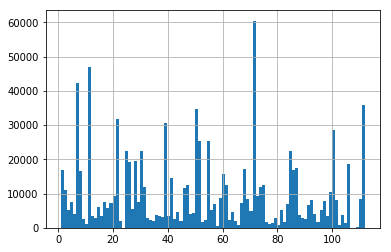

In [88]:
heroes.hist(bins = 100)

### 4 Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [80]:
n = heroes.max()
X_pick = np.zeros((X.shape[0], n))

for i, match_id in enumerate(X.index):
    for p in range(5):
        X_pick[i, X.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
X_pick_df = pd.DataFrame(X_pick)
X_pick_df.columns = range(1, 113)
cols = [col for col in X_pick_df.columns if col in heroes.unique()]
X_pick_df = X_pick_df[cols]

X_bag_words = pd.concat([X_lg, X_pick_df], axis = 1)

### 5 Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_bag_words, 
                                                    y,
                                                    test_size = 0.5, 
                                                    random_state = 1)

clf_lg_grid.fit(X_train, y_train)

y_train_score_lg = clf_lg_grid.decision_function(X_train)
y_test_score_lg = clf_lg_grid.decision_function(X_test)

print (clf_lg_grid.best_params_)
print (roc_auc_score(y_train, y_train_score_lg))
print (roc_auc_score(y_test, y_test_score_lg))

C:\Users\Lena\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Lena\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

C:\Users\Lena\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Lena\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

C:\Users\Lena\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Lena\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

{'C': 0.1}
0.7555502323218671
0.7506443264460052


полученное значение метрики выше, чем было без мешка слов. 

Это можно объяснить тем, что теперь каждый герой кодируется отдельной переменной и между идентификаторами героев нет линейных зависимостей, что хорошо подходит для логистической регрессии.

### 6 Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [ ]:
# считаем данные 
test_data = pd.read_csv('features_test.csv', index_col='match_id')
test_data = test_data.fillna(value = 0)
cols = [col for col in test_data.columns if col != 'start_time']

In [89]:
# сформируем data frame для лучшей модели
nn = len(test_data)
X_pick_test = np.zeros((nn, n))
# мешок слов:
for i, match_id in enumerate(test_data.index):
    for p in range(5):
        X_pick_test[i, test_data.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, test_data.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

X_pick_df_test = pd.DataFrame(X_pick_test)
X_pick_df_test.columns = range(1, 113)
cols = [col for col in X_pick_df_test.columns if col in heroes.unique()]

X_pick_df_test = X_pick_df_test[cols]
X_pick_df_test.head()

,1,2,3,4,5,6,7,8,9,10,...,100,101,102,103,104,105,106,109,110,112
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
cols = [col for col in test_data.columns if col not in ['start_time',
                                                       'duration', 
                                                       'tower_status_radiant', 
                                                       'tower_status_dire', 
                                                       'barracks_status_radiant',
                                                       'barracks_status_dire']]

X_scaled_test = pd.DataFrame(scaler.transform(test_data[cols]))
X_scaled_test.columns = test_data[cols].columns
cols = [col for col in test_data.columns if col not in ['start_time',
                                                       'duration', 
                                                       'tower_status_radiant', 
                                                       'tower_status_dire', 
                                                       'barracks_status_radiant',
                                                       'barracks_status_dire',
                                                       'r1_hero', 'd1_hero', 
                                                       'r2_hero', 'd2_hero', 
                                                       'r3_hero', 'd3_hero', 
                                                       'r4_hero', 'd4_hero', 
                                                       'r5_hero', 'd5_hero',
                                                            'lobby_type']]
X_bag_test = pd.concat([X_scaled_1[cols], X_pick_df_1], axis = 1)
X_bag_test.head()

,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,...,100,101,102,103,104,105,106,109,110,112
0,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,-0.316298,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,0.607286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,-1.176562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,-0.451669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,-0.314114,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
logistic = clf_lg_grid.best_estimator_.predict_proba(X_bag_test)
result = pd.DataFrame(zip(test_data.index, logistic[:, 1]))
result.columns = ['match_id', 'radiant_win']

print ('Min probability:', str(min(result['radiant_win'])))
print ('Max probability:', str(max(result['radiant_win'])))
result.to_csv('result_dota.csv', index = False)

Min probability: 0.007315778981536397
Max probability: 0.9964543775721515
